# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [1]:


# Load useful library kl

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb ,rgb2luv, luv2rgb
from matplotlib import cm
from sklearn.cluster import MeanShift, estimate_bandwidth
import cv2

# Usefull functions
def imshow(I, title=None, size=500, axis=False):
    """ display an image, with title, size, and axis """
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()

def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255  
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2

def viewQuantizedImage(I,pal):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[ int(h), int(s), int(v), :]
    return Iview/255

def display5mainColors(histo, pal):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal[idx[i], 0]
        Ia[0,0,1] = pal[idx[i], 1]
        Ia[0,0,2] = pal[idx[i], 2]
        plt.subplot(1, K, i+1)
        plt.imshow(Ia)
        plt.axis('off')
    plt.show()


def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()
    
def display_gif(fn):
    from IPython import display
    return display.HTML('<img src="{}">'.format(fn))



## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [5]:
def quantize(v,K):
    return (np.where(v==1, K-1, np.floor(v*K))).astype(int)


# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255.,8)] += 1
assert (h == 32*np.ones((8))).all()

2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [6]:
def quantizeImage(I, nH, nS, nV):
    Iq = np.zeros(I.shape).astype(int)
    Iq[:,:,0] = quantize(I[:,:,0], nH)
    Iq[:,:,1] = quantize(I[:,:,1], nS)
    Iq[:,:,2] = quantize(I[:,:,2], nV)

    Hist = np.zeros((nH, nS, nV))

    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            Hist[Iq[i,j,0], Iq[i,j,1], Iq[i,j,2]] += 1
            
    return Iq,Hist




3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [7]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H,2)

In [8]:


w,h=400,400
def test_exo_1(I,nH,nS,nV):
    I_hsv=rgb2hsv(I)
    
    Iq,HistoIq=quantizeImage(I_hsv,nH,nS,nV)
    pal1, pal2 = setColors(nH, nS, nV)
   



    Iq_RGB=viewQuantizedImage(Iq,pal2)
    
    histo=normalize(HistoIq.flatten())

    fig = plt.figure(figsize=(w/60,h/60), layout="constrained")
    spec = fig.add_gridspec(6, 6)

    ax0 = fig.add_subplot(spec[0:3, :3])
    ax0.imshow(I)
    ax0.set_title("original")
    ax0.set_axis_off()

    ax1 = fig.add_subplot(spec[0:3, 3:])
    ax1.imshow(Iq_RGB)
    ax1.set_title("Quantized")
    ax1.set_axis_off()

    ax2 = fig.add_subplot(spec[4:, :])
    ax2.hist(histo,bins=256)
    ax2.set_title("Histogram")

    K = 6
    
    ## Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:K]
    hsv_most_prevalent = [np.unravel_index(idx,( nH, nS , nV )) for idx in idx_most_prevalent]


    idx = np.argsort(histo)
    idx = idx[::-1]
    

    for i in range (K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0,0,0] = pal1[idx[i], 0]
        Ia[0,0,1] = pal1[idx[i], 1]
        Ia[0,0,2] = pal1[idx[i], 2]
        ax_tmp = fig.add_subplot(spec[3, i])
        ax_tmp.axis('off')
        ax_tmp.imshow(Ia)



In [5]:
plage=np.array(Image.open("./figs/Figure_1.png"))[85:330,95:500,:3]

5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

In [8]:
display_gif("hsv_test5.gif")

Comme on peut le voir en faisant varier H on fait varier les couleurs de l'image. (Le fait que toutes les couleurs ne varient pas est juste dû à la fonction de variation des couleurs qui n'est pas très bien choisie.. (on a paris abs(cos(t))))
En faisant varier S la saturation des couleurs et avec V leur brillance.

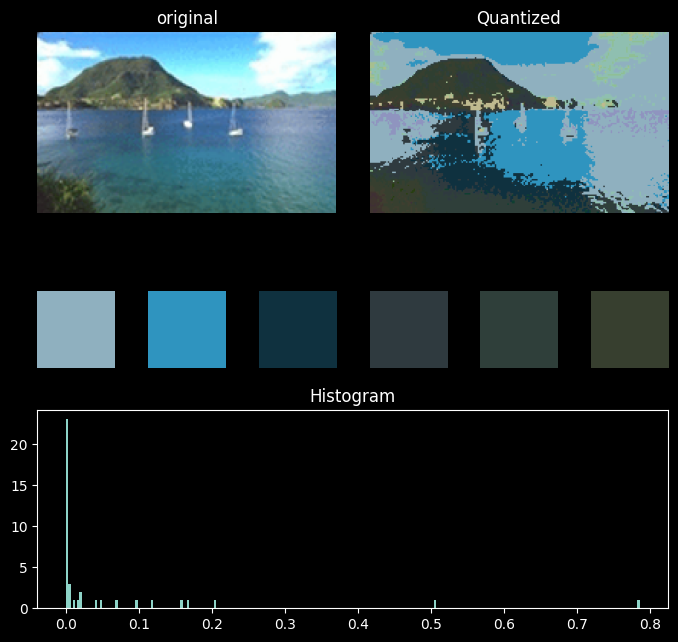

In [9]:
test_exo_1(plage,10,2,2)

6) What can you say about the results?

Les paramètres nH, nS et nV permettent de choisir avec quels paramètres on va segmenter les zones de l'image.

- H : la teinte des régions
- S : la saturation
- V : la brillance

La valeur qu'on donne à ces paramètres permet d'avoir une segmentation plus "fine" en ajustant le poids des composantes citées au dessus, cependant le nombre de couleurs totales valant (nH * nS * nV ) il ne faut pas prende des paramètres trop élevés au risque d'avoir une segmentation trop fine. (Dans le cas d'une table de hachage on cherche à limiter les colisions mais pas "trop" afin de pouvoir classer des images dans la même section)

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [10]:
import os
from scipy.io.matlab.mio import loadmat, savemat

#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 30
nS = 10
nV = 2

bcomputed =True# Set to False to compute the histogramm database

if not bcomputed:
    listImage = os.listdir(pathImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in listImage:
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            print( imageName)
            
            if (imageName=='._Liontigre20.png'):
                continue
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I);
            # Image quantization (your function tested in Exo 1)
            _,histo = quantizeImage(J, nH, nS, nV)
  
            # flat a 3D histogram in 1D
            histo = histo.flatten()
            
            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))
            
            

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_9991/2564247074.py:2: DeprecationWarning: Please use `loadmat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat
/var/folders/7t/84clpkws78x2jhnt808jfvz00000gn/T/ipykernel_9991/2564247074.py:2: DeprecationWarning: Please use `savemat` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio` namespace is deprecated.
  from scipy.io.matlab.mio import loadmat, savemat


### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [11]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']
a=np.array([[1,2,3],[4,5,6]])
def similarityMatrix(T) :
    T1=T
    
    T1=np.tile(T1,T.shape[0]).reshape(T.shape[0],T.shape[0],T.shape[1])
    
    T2=T1
    T2=np.transpose(T2,(1,0,2))
  
    return np.sqrt(np.sum(np.square(T2-T1),axis=2))
    

In [12]:
#S=similarityMatrix(listHisto)

In [13]:
#np.savetxt('data_similarity_matrix.csv', S, delimiter=',')
S=np.loadtxt('data_similarity_matrix.csv', delimiter=',')

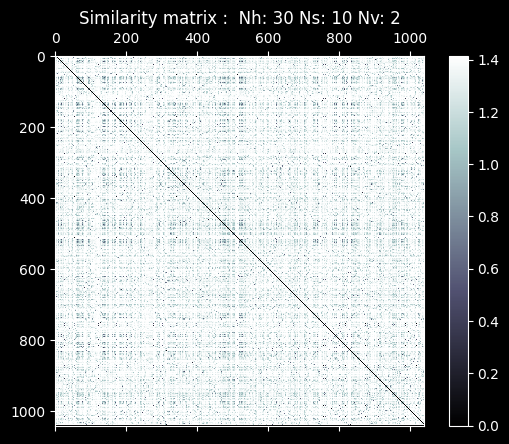

In [30]:
fig = plt.figure()
    
ax = fig.add_subplot(1, 1, 1)
mat=ax.matshow(S,cmap='bone')
ax.set_title("Similarity matrix :  Nh: "+str(nH)+" Ns: "+str(nS)+" Nv: "+str(nV))
plt.savefig('gen_gif_'+str(1)+'.png')


fig.colorbar(mat, orientation='vertical')
    
    

2. Display the matrix `S`  as an image. What can we say about this it ?

On observe que la diagonale est bien remplie de 1 et que la matrice est symétrique.

En augmentant le nombre de paramètres (nH * Ns * Nv) on pourra observer que le nombre de zones foncées sur l'image va devenir de plus en plus petit puisqu'on va affiner les critères de ressemblance. (La distance entre deux images va augmenter puisqu'on ajoute des dimensions à chaque image.) Cette amélioration de la classification se fait au détriment du temps de calcul qui est exponentiellement plus long lorsque que l'on augmente les paramètres.

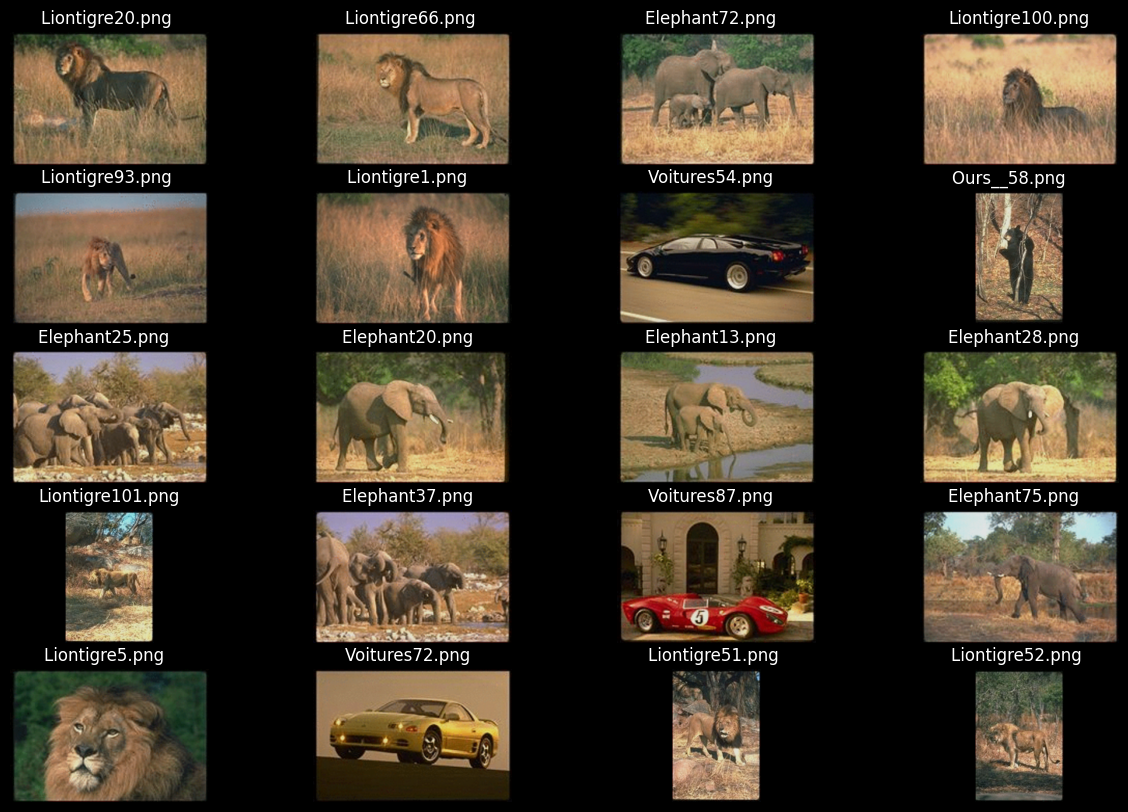

In [17]:
indexQuery = 350
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()


4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


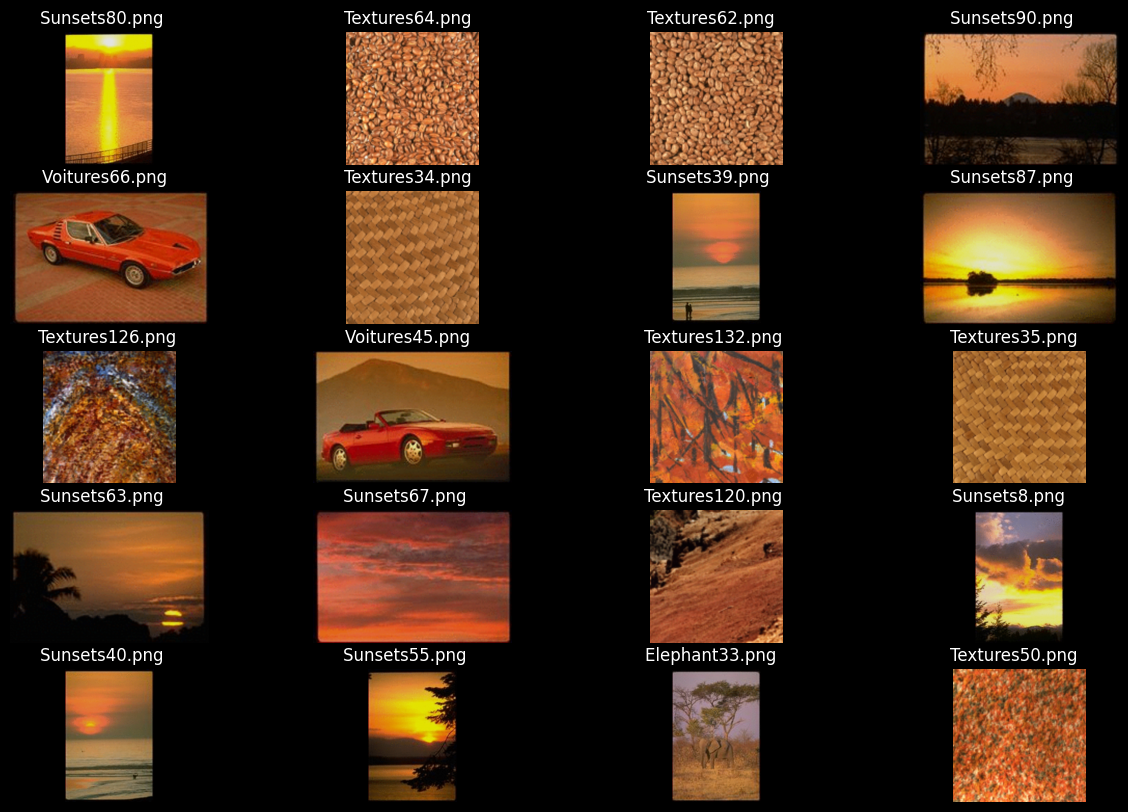

In [79]:
indexQuery1 = np.random.randint(0, len(listImage))
display20bestMatches(S, indexQuery1)
imageName = (pathImage+listImage[indexQuery1]).strip()


5. What can you say about the results ? What are the limitations and the advantages of this method ?

On peut observer que l'algo ressort bien des images avec des couleurs similaires. Cependant l'algo ne prend jamais en compte la géomtrie des images. On aurait peut-être pu ajouter un système de keypoints par images pour avoir de meilleurs résultats. 

A l'opposé, l'algorithme BRIEF prend en compte la géométrie des images (dans une certaine mesure).

# BRIEF DESCRIPTOR - face recognition

## Types de masques

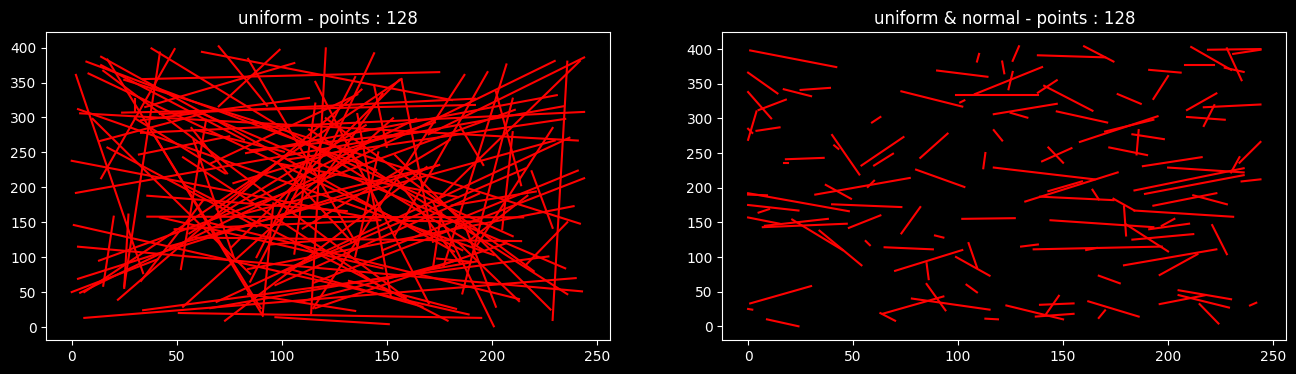

In [92]:
def create_comp_points_uniform(I,n):
    return (np.random.uniform(0,1,(n,4))*np.array([I.shape[0],I.shape[1],I.shape[0],I.shape[1]])).astype(int)

def create_comp_points_normal(I,n):
    p1=np.random.uniform(0,1,(n,2))*np.array([I.shape[0],I.shape[1]])
    res=np.zeros((n,4))
    for i in range(p1.shape[0]):
        res[i,0]=p1[i,0]
        res[i,1]=p1[i,1]
        res[i,2]=p1[i,0]+np.random.normal(0,25)
        res[i,3]=p1[i,1]+np.random.normal(0,25)
        if res[i,2]<0:
            res[i,2]=0
        if res[i,2]>I.shape[0]:
            res[i,2]=I.shape[0]-1
        if res[i,3]<0:
            res[i,3]=0
        if res[i,3]>I.shape[1]:
            res[i,3]=I.shape[1]-1
        
    return res.astype(int)
p=create_comp_points_uniform(plage,128)
p1=create_comp_points_normal(plage,128)

    
    
    
    

def show_compirison_points(I,p,p1):

    fig = plt.figure(figsize=plt.figaspect(0.25))
    
    ax = fig.add_subplot(1, 2, 1)
    #ax.xlim(0, I.shape[0])
    #ax.ylim(0, I.shape[1])
    ax.set_title("uniform - points : "+str(p.shape[0]))
    for k in p:
        ax.plot([k[0],k[2]],[k[1],k[3]],'r')

    ax = fig.add_subplot(1, 2, 2)
    
    ax.set_title("uniform & normal - points : "+str(p.shape[0]))
    for k in p1:
        ax.plot([k[0],k[2]],[k[1],k[3]],'r')

    
    plt.show()
show_compirison_points(plage,p,p1)

In [93]:
def tau(p1,p2):
    return (p1<p2).astype(int)

def BRIEF_desc(I,p):
    res=np.zeros(p.shape[0])
    tmp_I=rgb2hsv(I)
    for k in range(p.shape[0]):
        res[k]=tau(tmp_I[p[k,0],p[k,1],0],tmp_I[p[k,2],p[k,3],0])
    return res

print(BRIEF_desc(plage,p).sum())

64.0


In [104]:
nb_personnes=10
p=create_comp_points_uniform(plage,1024)
visages=[cv2.blur(np.array(Image.open("./visages_2/"+str(x)+"_"+str(y)+".ppm")),(10,10)) for x in range(1,nb_personnes) for y in range(0,8)]
visages_clair=[np.array(Image.open("./visages_2/"+str(x)+"_"+str(y)+".ppm")) for x in range(1,nb_personnes) for y in range(0,8)]
labels=[str(x) for x in range(nb_personnes) for _ in range(0,8)]
#np.random.shuffle(visages)
kp=np.array([BRIEF_desc(I,p) for I in visages])
Sv=similarityMatrix(kp)


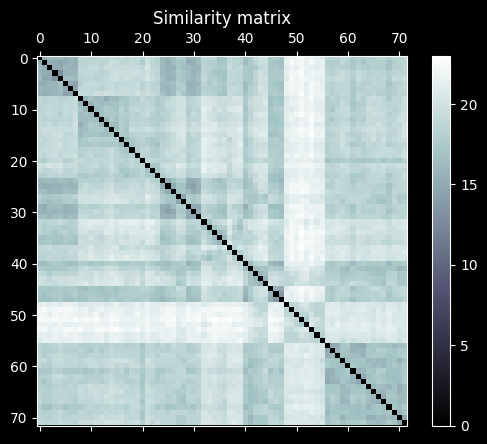

In [105]:
fig = plt.figure()
    
ax = fig.add_subplot(1, 1, 1)
mat=ax.matshow(Sv,cmap='bone')
ax.set_title("Similarity matrix" )
plt.savefig('gen_gif_'+str(1)+'.png')
fig.colorbar(mat, orientation='vertical')

def display5bestmatches(Mat,idx):
    Lmat=idx
    idx=np.argsort(Mat[idx,:])
    
    plt.figure(figsize=(15, 10))
    for i in range(5):
        plt.subplot(1,5,i+1)
        plt.imshow(visages_clair[idx[i]])
        if i==0:
            plt.title("Query")
        else:
            plt.title("score : "+str(np.around(Mat[Lmat,idx[i]],2)))
        plt.xlabel("Label : "+str(labels[idx[i]]))
    plt.show()


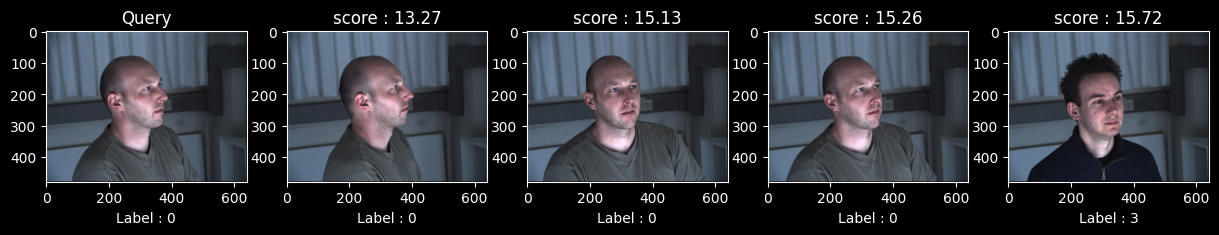

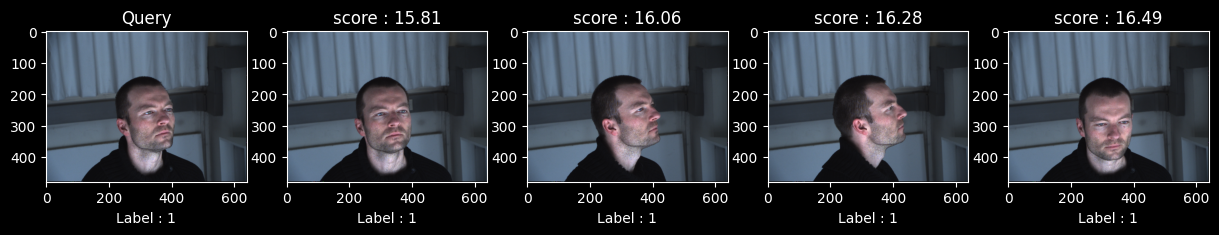

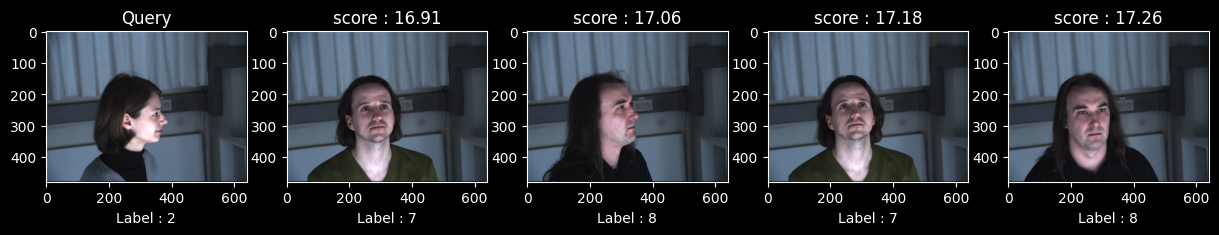

In [109]:
display5bestmatches(Sv,3)
display5bestmatches(Sv,9)
display5bestmatches(Sv,20)

## Evaluation

Nous n'avons pas pu faire tourner l'algo BRIEF sur la base de données précédentes car il faut que toutes les images aient la même dimension pour leur appliquer le masque.



Pour évaluer les performances on a annoté tous les portrais de chaque personne dans la BD/ Chaque personne a 7 portraits pris dans des angles différents dans la base. Nous avons a chaque fois mesuré si les 7 premiers portraits que l'algo ressort pour chaque recherche correspond bien à la personne recherchée.

32  done :  30.11  /  16.85
64  done :  46.93  /  25.19
128  done :  57.8  /  32.27
256  done :  66.6  /  44.08
512  done :  71.08  /  54.48
1024  done :  73.25  /  63.35
2048  done :  74.5  /  69.08


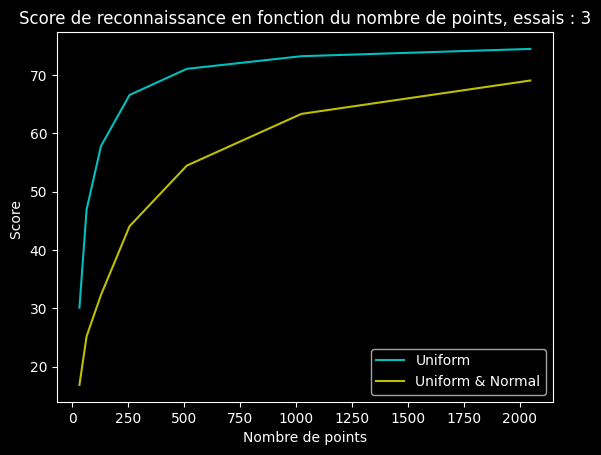

In [103]:
def get_score(Mat,labels_,idx):
    Lmat=idx
    idx=np.argsort(Mat[idx,:])
    score=0
    for i in range(1,8):
        if labels_[idx[i]]==labels_[Lmat]:
            score+=1
    return score/7.0

def score_test(Mat,labels_):
    score=0
    idxs=np.arange(0,Mat.shape[0],1)

    for tmp_id in idxs:
        score+=get_score(Mat,labels_,tmp_id)
    return (score/idxs.shape[0])*100



def score_nb_points(L,labels,n):
    points=create_comp_points_uniform(L[0],n)
    kp=np.array([BRIEF_desc(I,points) for I in L])
    tmp_S=similarityMatrix(kp)
    return score_test(tmp_S,labels)

def score_nb_points_n(L,labels,n):
    points=create_comp_points_normal(L[0],n)
    kp=np.array([BRIEF_desc(I,points) for I in L])
    tmp_S=similarityMatrix(kp)
    return score_test(tmp_S,labels)
    
score_nb_points(visages,labels,512)

def eval_generale(essais=10):
    x=[32,64,128,256,512,1024,2048]
    y=[]
    y1=[]
    
    for n_tmp in x:
    
        moy=0
        moy1=0
        for i in range(essais):
            moy+=score_nb_points(visages,labels,n_tmp)
            moy1+=score_nb_points_n(visages,labels,n_tmp)
        y.append(np.around(moy/essais,2))
        y1.append(np.around(moy1/essais,2))
        print(n_tmp," done : ",y[-1]," / ",y1[-1])

    
    plt.plot(x,y,'c',label='Uniform')
    plt.plot(x,y1,'y',label='Uniform & Normal')
    plt.xlabel("Nombre de points")
    plt.ylabel("Score ")
    plt.title("Score de reconnaissance en fonction du nombre de points, essais : "+str(essais))
    plt.legend()
    plt.show()

eval_generale(essais=3)

    

# Génération de gifs

NameError: name 'variation_HSV' is not defined

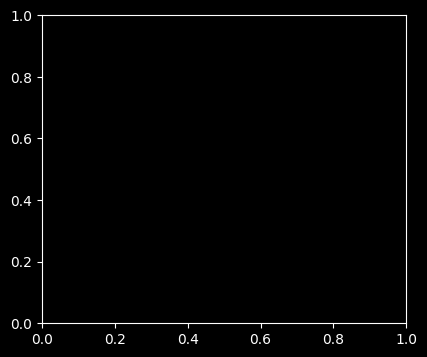

In [42]:
nb_images=64

w,h=400,400

tmp_img_vert=np.zeros((w,h,3))
tmp_img_vert[:,:]=np.array([10.,207.,184.])

tmp=rgb2hsv(tmp_img_vert)
periode=1e-1
for i in range(0,nb_images,1):
    
    fig = plt.figure(figsize=plt.figaspect(0.25))
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(hsv2rgb( variation_HSV(tmp,np.abs(np.cos(periode*i)),1,1)))
    ax.set_title("varying H")
    
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(hsv2rgb(variation_HSV(tmp,1,np.abs(np.cos(periode*i)),1)))
    ax.set_title("varying S")
    
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(hsv2rgb(variation_HSV(tmp,1,1,np.abs(np.cos(periode*i)))))
    ax.set_title("varying V")
    

    plt.savefig('gen_gif_'+str(i)+'.png')
    plt.close()

In [18]:
nom_gif="hsv_test6.gif"


with imageio.get_writer(nom_gif, mode='I') as writer:
    for i in range(1,nb_images,1):
        image = imageio.v2.imread('gen_gif_'+str(i)+'.png')
        writer.append_data(image)

for i in range(1,nb_images,1):
    os.remove('gen_gif_'+str(i)+'.png') 

In [19]:
display_gif(nom_gif)